- target: Using softmax


In [1]:
def base_softmax(arr):
    exp_arr = np.exp(arr)
    sum_exp_arr = np.sum(exp_arr)
    y = exp_arr / sum_exp_arr
    return y

# Import

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import tensorflow.keras.layers as KL
import tensorflow.keras.models as KM
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt

# Load Data & Read description

In [3]:
data = load_iris()

In [4]:
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [5]:
print(data["DESCR"])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [6]:
df = pd.DataFrame(data["data"], columns=data["feature_names"])
df["target"] = data["target"]
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


# Define feature / target - one-hot encoding

In [7]:
feature_data = df.drop("target", axis=1)
target_data = pd.get_dummies(df["target"])

# Split train test

In [8]:
train_X, test_X, train_y, test_y = train_test_split(feature_data, target_data, test_size=0.2, random_state=0)

# Stacking DL layers

In [9]:
inputs = KL.Input(shape=(train_X.shape[-1]))
x = KL.Dense(512, activation="relu")(inputs)
x = KL.Dense(512, activation="relu")(x)
x = KL.Dense(512, activation="relu")(x)
x = KL.Dense(test_y.shape[-1], activation="softmax")(x)
model = KM.Model(inputs, x)

inputs = KL.Input(shape=(train_X.shape[-1]))
x = KL.Dense(512, activation="relu")(inputs)
x = KL.Dense(512, activation="relu")(x)
x = KL.Dense(512, activation="relu")(x)
x = KL.Dense(test_y.shape[-1], activation="softmax")(x)
model_custom_loss = KM.Model(inputs, x)
model_custom_loss.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               2560      
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 1539      
Total params: 529,411
Trainable params: 529,411
Non-trainable params: 0
_________________________________________________________________


# Define Loss

In [10]:
class CustomCategoricalCrossEntropy(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    
    def call(self, y_pred, y_true):
        delta = 1e-7
        loss = -K.sum(y_true * K.log(K.l2_normalize(K.cast(y_pred, tf.float32), axis=0) + delta))
        return loss

In [11]:
? tf.keras.losses.CategoricalCrossentropy

# Callbacks

In [12]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=3,
        verbose=0,
        mode='auto'
    ),
    ModelCheckpoint(
        filepath='./model.h5',
        verbose=1,
        save_best_only=True
    )
]
model.compile(
    loss=CustomCategoricalCrossEntropy(),
    optimizer="adam",
    metrics=["accuracy"],
    loss_weights=None,
    sample_weight_mode=None,
    weighted_metrics=None,
    target_tensors=None
)

model_custom_loss.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer="adam",
    metrics=["accuracy"],
    loss_weights=None,
    sample_weight_mode=None,
    weighted_metrics=None,
    target_tensors=None
)

# Fitting

In [13]:
hist = model.fit(
    train_X.values,
    train_y.values,
    epochs=30,
    callbacks=callbacks,
    batch_size=16,
    verbose=1,
    validation_split=0.1,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None
)

hist_custom_loss = model_custom_loss.fit(
    train_X.values,
    train_y.values,
    epochs=30,
    callbacks=callbacks,
    batch_size=16,
    verbose=1,
    validation_split=0.1,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None
)

Train on 108 samples, validate on 12 samples
Epoch 1/30
 16/108 [===>..........................] - ETA: 3s - loss: 173.3669 - accuracy: 0.3750
Epoch 00001: val_loss improved from inf to 96.56858, saving model to ./model.h5
108/108 [==============================] - 1s 7ms/sample - loss: 148.1734 - accuracy: 0.4722 - val_loss: 96.5686 - val_accuracy: 0.5833
Epoch 2/30
 16/108 [===>..........................] - ETA: 0s - loss: 120.5034 - accuracy: 0.6875
Epoch 00002: val_loss improved from 96.56858 to 86.25201, saving model to ./model.h5
108/108 [==============================] - 0s 630us/sample - loss: 94.5967 - accuracy: 0.7037 - val_loss: 86.2520 - val_accuracy: 0.5833
Epoch 3/30
 16/108 [===>..........................] - ETA: 0s - loss: 76.1611 - accuracy: 0.7500
Epoch 00003: val_loss improved from 86.25201 to 85.31454, saving model to ./model.h5
108/108 [==============================] - 0s 639us/sample - loss: 84.4107 - accuracy: 0.7037 - val_loss: 85.3145 - val_accuracy: 0.5833
Ep

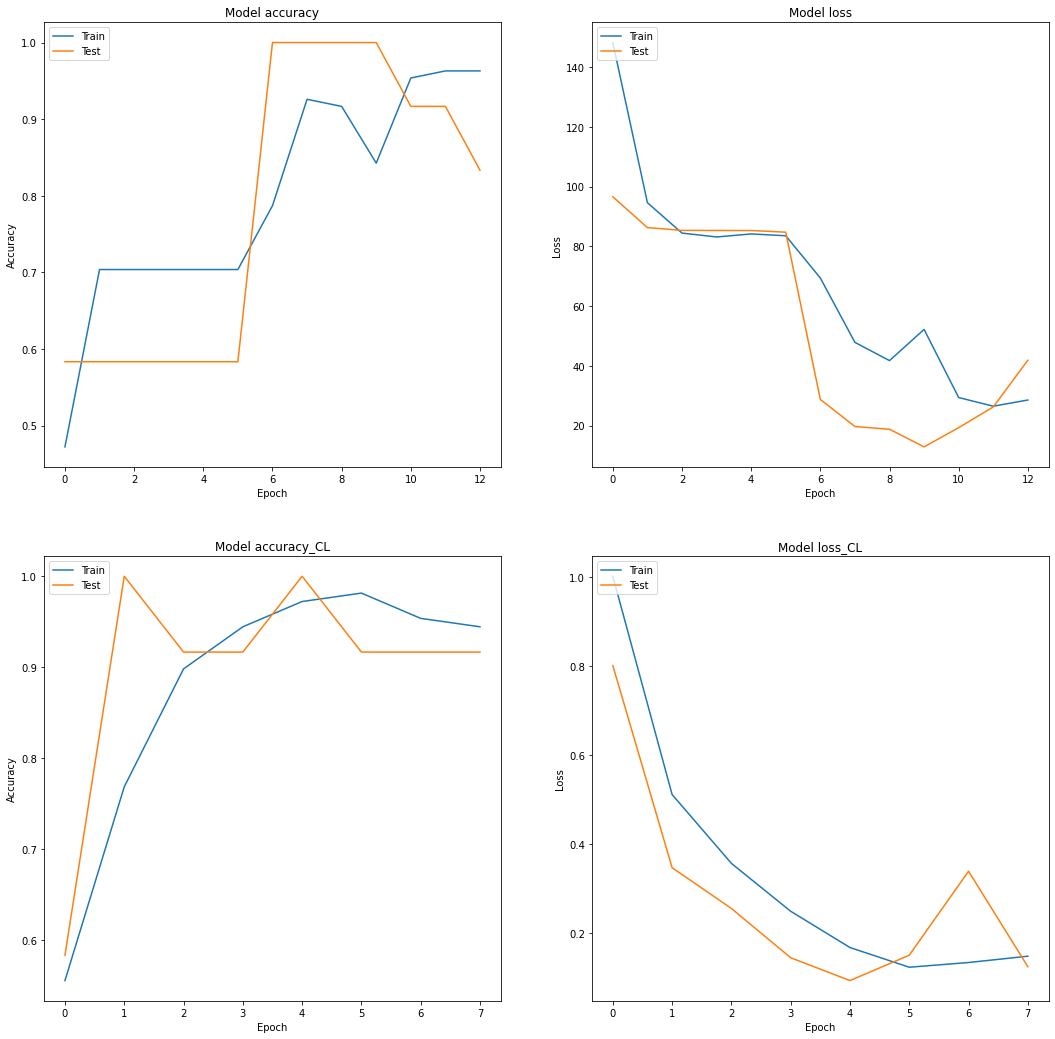

In [14]:
fig = plt.figure(figsize=(18,18))


# Plot training & validation accuracy values
ax = fig.add_subplot(2, 2, 1)
ax.plot(hist.history['accuracy'])
ax.plot(hist.history['val_accuracy'])
ax.set_title('Model accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(2, 2, 2)
ax.plot(hist.history['loss'])
ax.plot(hist.history['val_loss'])
ax.set_title('Model loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation accuracy values
ax = fig.add_subplot(2, 2, 3)
ax.plot(hist_custom_loss.history['accuracy'])
ax.plot(hist_custom_loss.history['val_accuracy'])
ax.set_title('Model accuracy_CL')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(2, 2, 4)
ax.plot(hist_custom_loss.history['loss'])
ax.plot(hist_custom_loss.history['val_loss'])
ax.set_title('Model loss_CL')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='upper left')